# Yelp Review Analysis
**Team members:**  
Rahul Sapparapu (100890409) </br>
Jayarani Rajesh (100818850) </br>
Arunkumar Senthilkumar (100888951)  

# 1. Project Objective  

Our project will use Yelp reviews to conduct a comprehensive analysis of seven different types of restaurants (Korean, Japanese, Chinese, Vietnamese, Thai, French, and Italian). By examining the reasons behind customers' positive and negative reviews, we aim to identify factors that contribute to a restaurant's success and customer satisfaction, and provide recommendations for future growth. The potential value of Yelp's dataset as a source of business insights is highlighted by research that found a one-star increase on Yelp can lead to a 59% increase in revenue for independent restaurants.

# 2. Dataset

**Business Dataset:** This dataset contains information on various businesses listed on Yelp, including their name, address, city, state, postal code, latitude, longitude, review count, rating, categories, and more. The dataset covers businesses from over 200 cities in 4 countries, including the United States, Canada, the United Kingdom, and Australia. The dataset is available in JSON format and can be downloaded from the Yelp Dataset Challenge website.

**Review Dataset:** This dataset contains user-generated reviews for various businesses listed on Yelp. The dataset includes information on the business being reviewed, the user who wrote the review, the text of the review, the rating given by the user, and more. The dataset covers reviews from over 200 cities in 4 countries and is available in JSON format.

**Source Link:** https://www.yelp.com/dataset/documentation/main

To download these datasets, you will need to create a Yelp account and agree to their terms of use. Once you have done that, you can download the datasets from the Yelp Dataset Challenge website.

Yelp also offers other datasets, including user dataset, check-in dataset, and tip dataset, which you may find useful for other projects. However, for your current project, the business and review datasets should be sufficient.

# 3.  Summary of Progress 

Our data pre-processing pipeline involves selection and filtering, cleaning, reshaping and reindexing, visualization, manipulation, and merging multiple data sets. We start by filtering out the 50 US states and all restaurants. Then, we categorize restaurants by cuisine type and remove null categories, delete quotation marks, and label restaurants based on their ratings.

We extract features from review texts using 'bag of words' and an SVM model, and reindex the data frame with a new category column. Seaborn is used to visualize restaurant and review distributions, and identify top positive/negative words for each cuisine type. We calculate 'polarity scores' for each restaurant category by multiplying word sentiment scores by their frequency and normalizing by total reviews.

Finally, we merge the business and review data sets for analysis.

# 4. Progress in Coding 

## Data Preparation

In [1]:
import pandas as pd
import seaborn as sns
%pylab inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
#pd.set_option('display.height', 1000)  //Depricated
pd.options.display.max_rows = 1000   #use this instead of height
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


### Clean Yelp_business dataset 

In [2]:
business = pd.read_csv('yelp_dataset/business.csv')
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
## drop unuseful column 'neighborhood' 
business.drop(['attributes'], axis=1, inplace=True)
business.drop(['hours'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
usa.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food"


In [4]:
## select all restaurants in USA
usa = usa.dropna(subset=['categories'])
restaurants = []
for index, row in usa.iterrows():
    if 'Restaurants' in row['categories']:
        restaurants.append(row)
us_restaurants = pd.DataFrame(restaurants)

In [5]:
us_restaurants.is_copy = False
us_restaurants['category'] = pd.Series(dtype='object')
categories = ['American', 'Mexican', 'Italian', 'Japanese', 'Chinese', 'Thai', 'Mediterranean', 'French', 'Vietnamese', 'Greek', 'Indian', 'Korean', 'Hawaiian', 'African', 'Spanish', 'Middle_eastern']

for category in categories:
    us_restaurants.loc[us_restaurants.categories.str.contains(category), 'category'] = category

us_restaurants.category[:20]

3            NaN
5            NaN
8          Greek
9            NaN
11    Vietnamese
12      American
14       Italian
15      Japanese
19        Korean
22           NaN
23       Italian
24           NaN
27      Japanese
28       Italian
29           NaN
31           NaN
33           NaN
35      American
36           NaN
41       Italian
Name: category, dtype: object

In [6]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,American


In [7]:
## check total number of us restaurants
us_restaurants.shape

(28450, 12)

In [8]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [9]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
category         object
dtype: object

In [10]:
## check missing values
us_restaurants.isnull().sum()

business_id       0
name              0
address         170
city              0
state             0
postal_code       4
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
category          0
dtype: int64

### Clean yelp_review dataset

In [11]:
## load review table
# Load the large dataset in chunks
chunks = pd.read_csv("yelp_dataset/reviews.csv", chunksize=100000)
# Concatenate the chunks into a single dataframe
review = pd.concat(chunk for chunk in chunks)

In [12]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [13]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

### Merge two datasets and get new dataframe restaurants_reviews

In [14]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    

/var/folders/jw/mbych16x4ys6lr6mjvpwjt0m0000gn/T/ipykernel_4591/2905545444.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \


In [15]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0,0,0,0,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59,53,positive
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0,0,0,0,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04,26,positive
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0,0,0,0,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01,184,negative
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0,0,0,0,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34,186,negative
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0,3,0,0,Three of us decided to try this place out last...,2012-12-17 18:37:23,224,negative


## Exploratory Data Analysis

### Restaurants Distribution

#### Distribution of restaurants in each category

In [16]:
plt.style.use('ggplot')

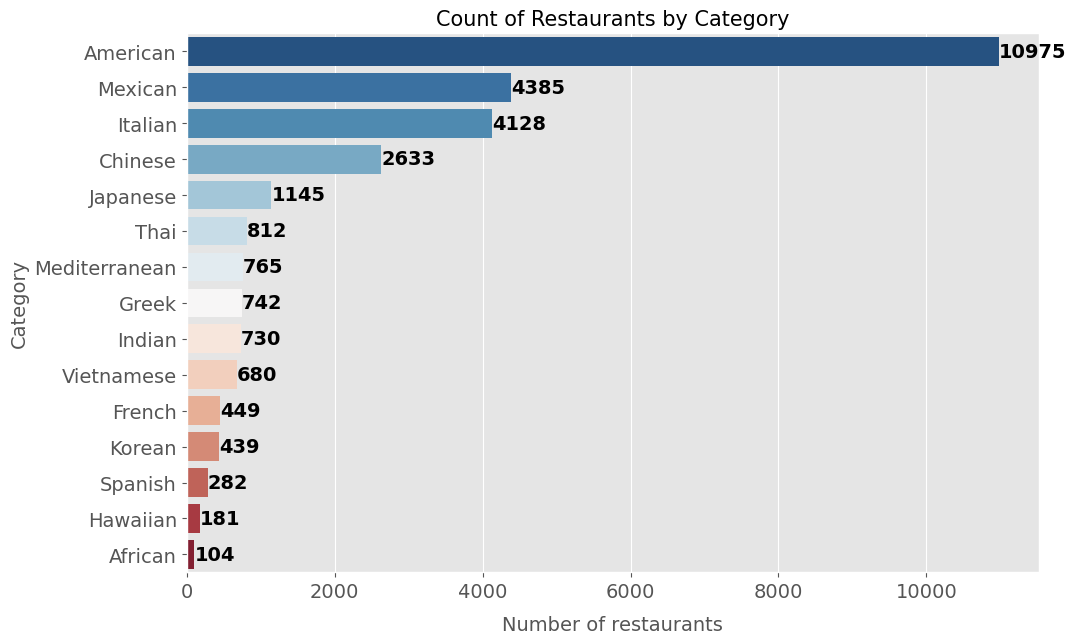

In [17]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

Categories in dark blue color have the largest number of restaurants. On the contrary, categories in dark red color have the least number of restaurants. The top 5 type of restaurants are American, Mexican, Italian, Chinese and Japanese. 

#### Top 10 cities with most restaurants

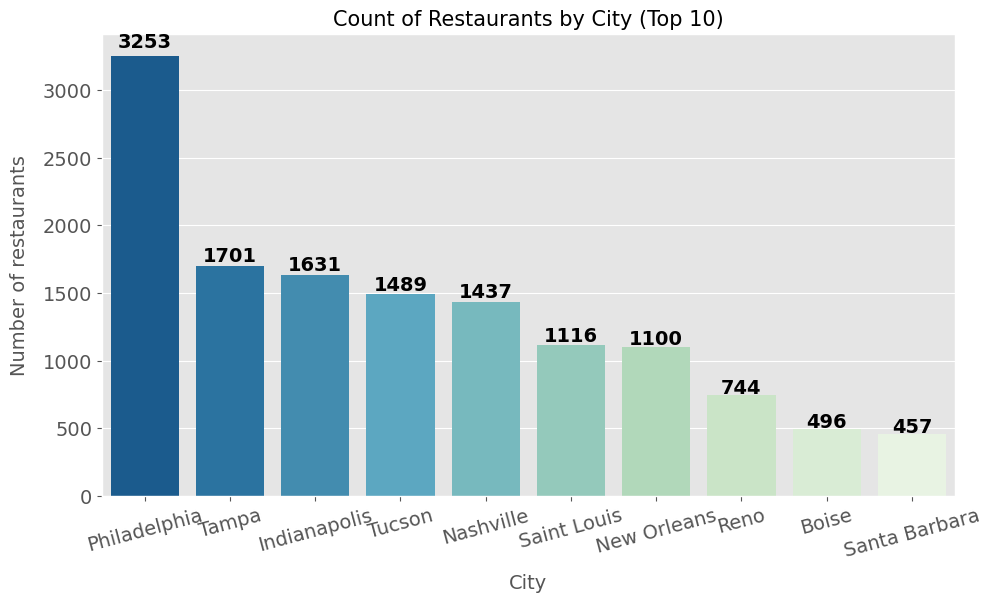

In [18]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(x = grouped.index, y = grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### Distribution of restaurants in each state

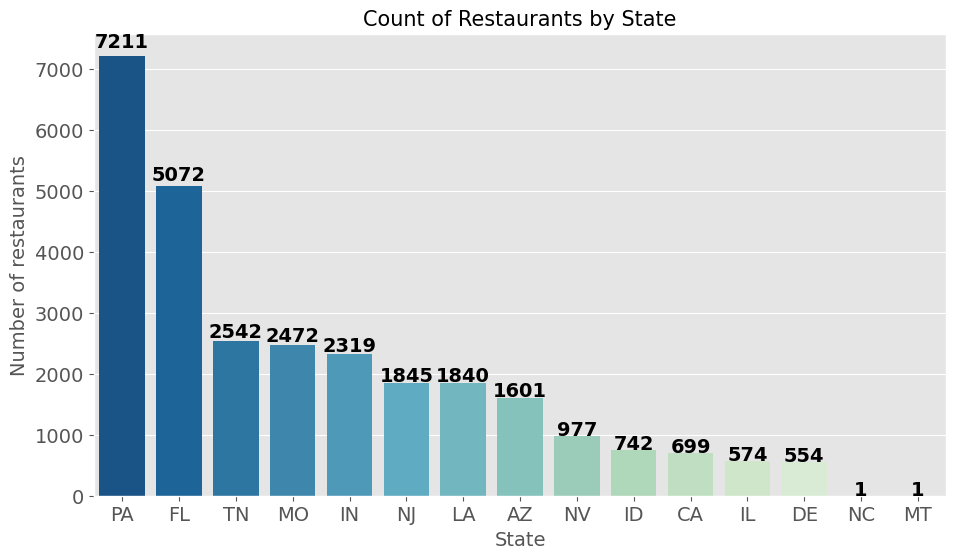

In [19]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(x = grouped.index, y = grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

### Reviews Distribution

#### Distribution of reviews by cuisine type

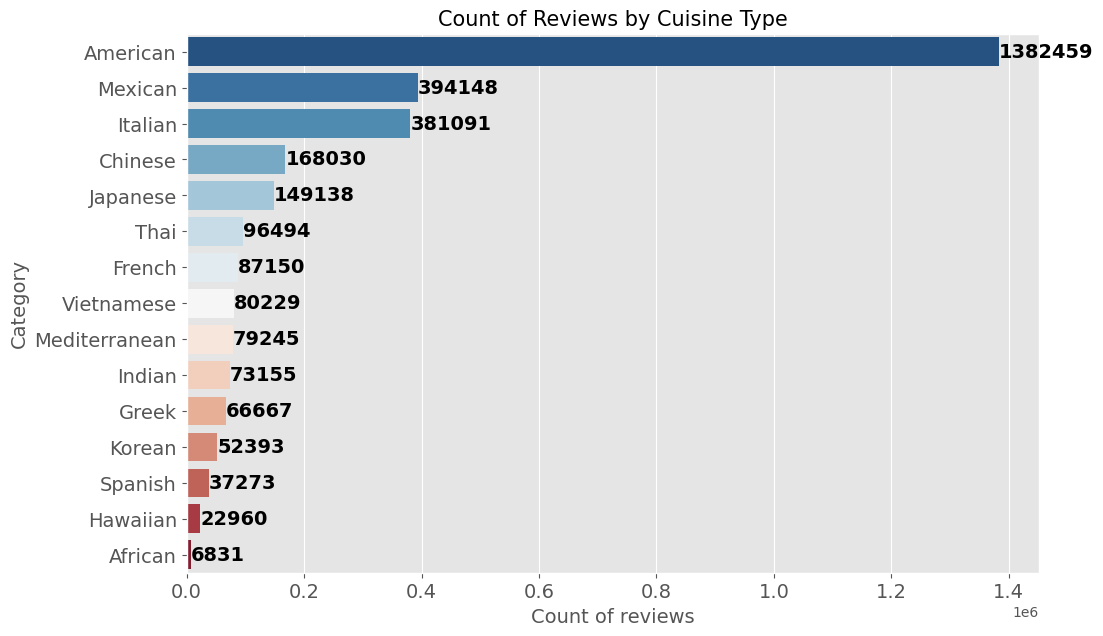

In [20]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

#### Top 10 cities with most reviews

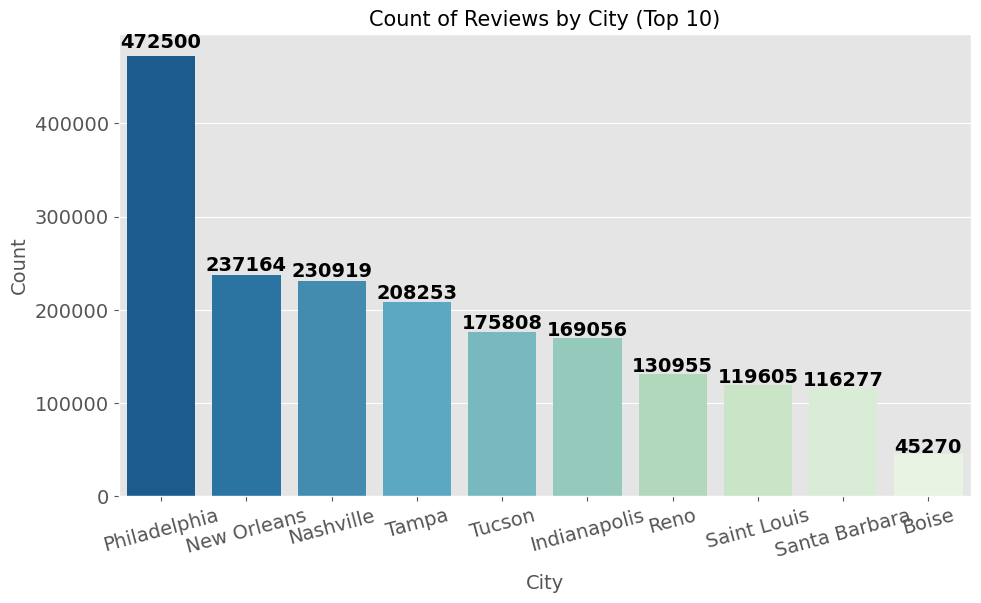

In [21]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(x = grouped.index, y = grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

#### Top 9 restaurants with most reviews

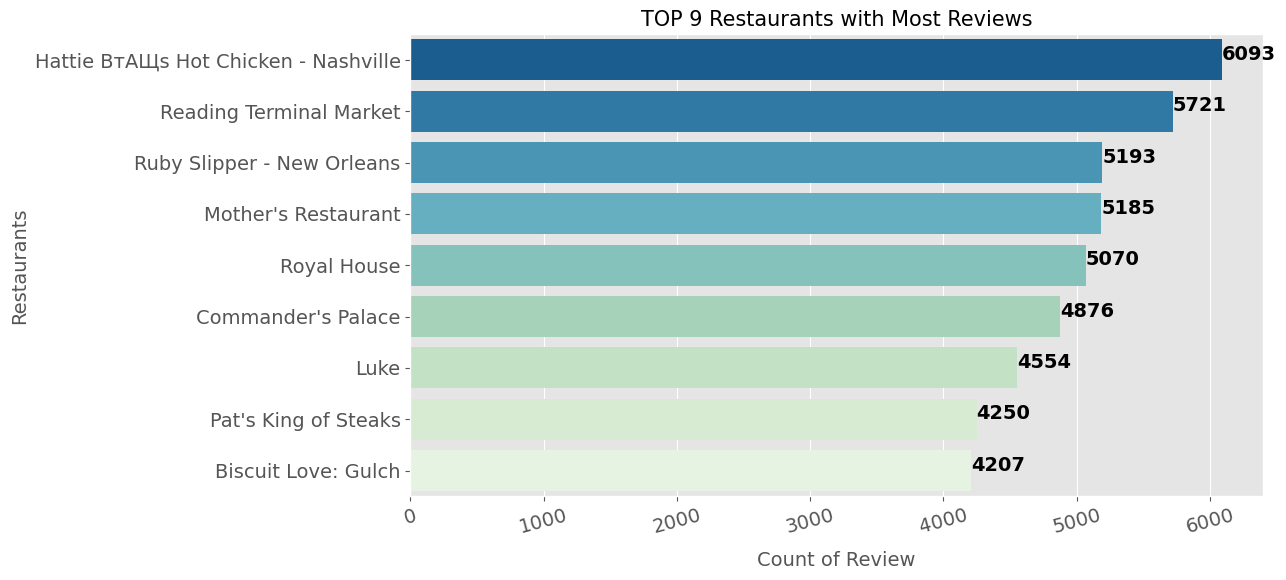

In [22]:
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:9]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 9 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

#### Distribution of positive and negative reviews in each category

In [23]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

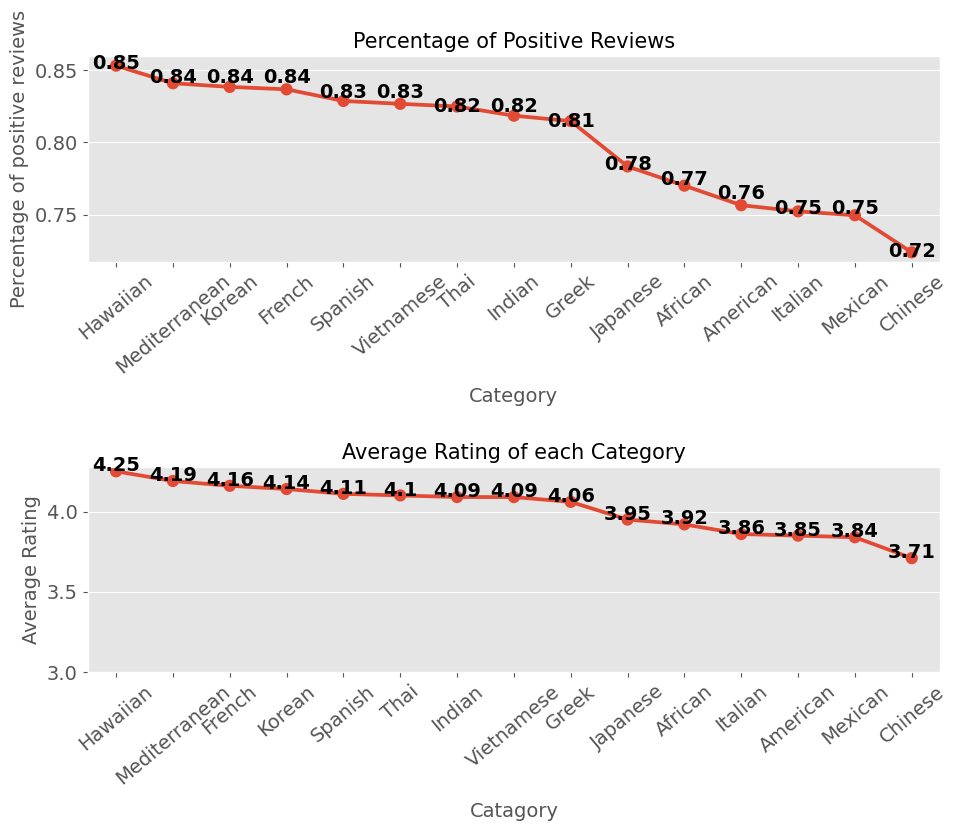

In [24]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(x = grouped.index, y = grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)

#### Average length of reviews

#### Average length of words in each category

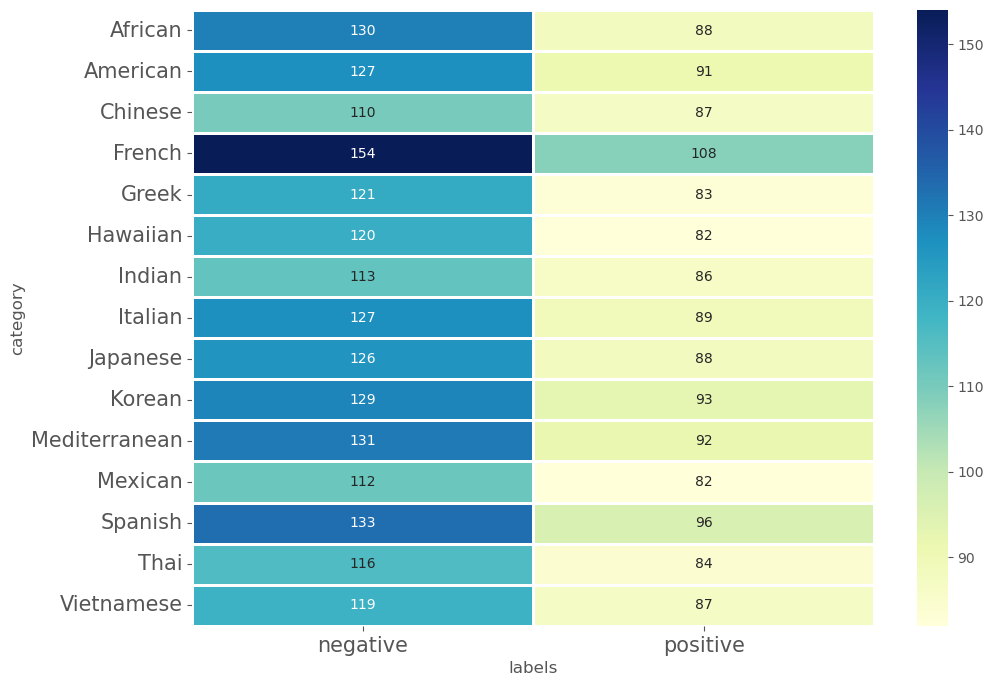

In [25]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

### Ratings Distribution

#### Distribution of ratings by restaurants

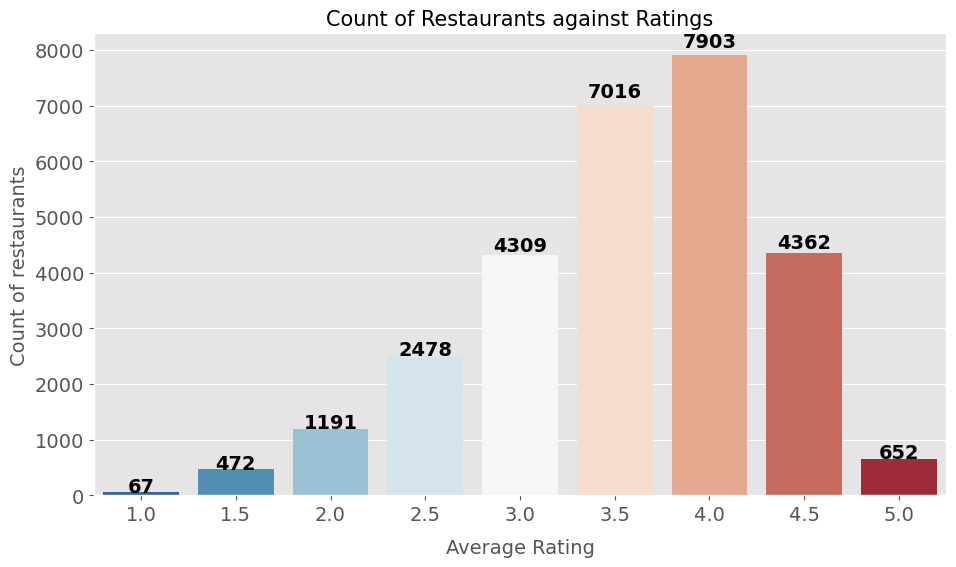

In [26]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(x = grouped.index, y = grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

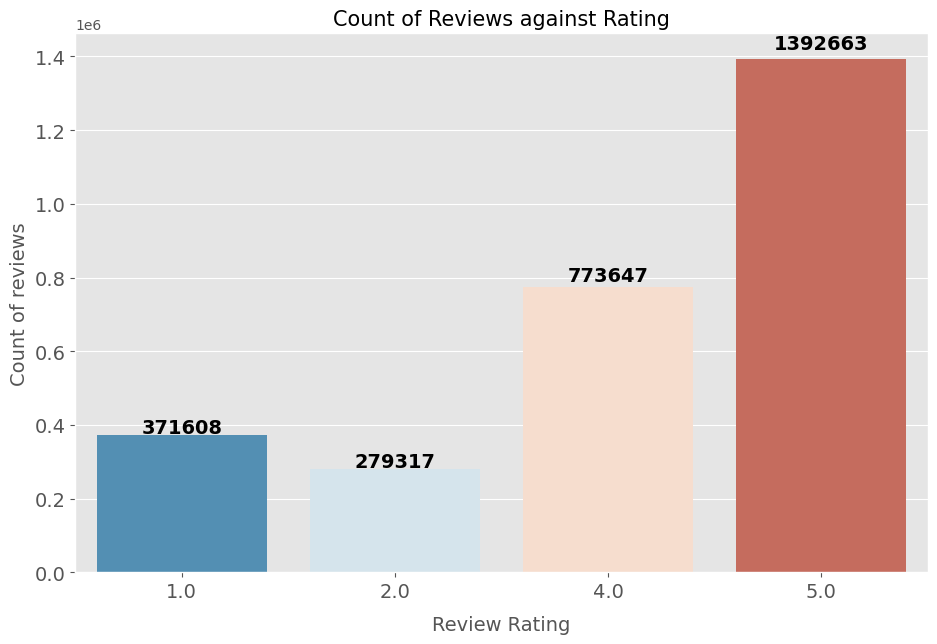

In [27]:
plt.figure(figsize=(11,7))
grouped = restaurants_reviews.review_star.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

## Review Analysis

### Positive words and negative words

In [28]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [29]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


/var/folders/jw/mbych16x4ys6lr6mjvpwjt0m0000gn/T/ipykernel_4591/3171667963.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \


In [30]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt', encoding='ascii')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt', encoding='windows-1250')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [31]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

### Use Korean as an example 

In [32]:
Korean_reviews = get_dataset('Korean')

In [33]:
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)

In [34]:
print('Total %d number of reviews' % Korean_train.shape[0])

Total 24133 number of reviews


In [35]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [36]:
## filter words
Korean_train.text = Korean_train.text.apply(filter_words)

In [37]:
## construct features and labels
terms_train=list(Korean_train['text'])
class_train=list(Korean_train['labels'])

terms_test=list(Korean_test['text'])
class_test=list(Korean_test['labels'])

In [38]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(24133, 2983)

In [39]:
## run model
svm = LinearSVC(max_iter = 1000000)
svm.fit(feature_train_counts, class_train)

LinearSVC(max_iter=1000000)

Support Vector Machine (SVM) model was applied to differentiate positive and
negative words in reviews, and further to get a word score to understand how positive or how negative the words are.

### Now we can calculate polarity score of each word in the specific category

#### Korean

In [40]:
## create dataframe for score of each word in a review calculated by svm model
#coeff = svm.coef_[0]
#Korean_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
vectorizer_filtered = CountVectorizer()
vectorizer_filtered.fit(Korean_train.text)
vocabulary = vectorizer_filtered.vocabulary_
feature_names = sorted(vocabulary, key=vocabulary.get)
Korean_words_score = pd.DataFrame({'score': coeff, 'word': feature_names})



In [41]:
feature_names = [word for word, index in vectorizer.vocabulary_.items()]
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=feature_names)
Korean_reviews['labels'] = class_train
Korean_frequency = Korean_reviews[Korean_reviews['labels'] =='positive'].sum()[:-1]

In [42]:
Korean_words_score.set_index('word', inplace=True)

In [43]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

‘polarity score’ (a value that reflects the polarity of
sentiment) towards each restaurant category, the sentiment
score of each word was first multiplied by its frequency, and
then normalized by the total number of reviews for the specific
category of restaurants.

𝑝𝑜𝑙𝑎𝑟𝑖𝑡𝑦_𝑠𝑐𝑜𝑟𝑒 𝑡, 𝑐 = 𝑠𝑐𝑜𝑟𝑒(𝑡)×
𝑡𝑜𝑡𝑎𝑙_𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡, 𝑐)
𝑛𝑢𝑚𝑏𝑒𝑟_𝑜𝑓_ 𝑟𝑒𝑣𝑖𝑒𝑤𝑠(𝑐)

𝑝𝑜𝑙𝑎𝑟𝑖𝑡𝑦_𝑠𝑐𝑜𝑟𝑒 𝑡, 𝑐 is the index for measuring how
essential word 𝑡 is among restaurants of type 𝑐

𝑡𝑜𝑡𝑎𝑙_𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡, 𝑐) is the total frequency of word 𝑡 in
all reviews of type 𝑐 restaurants

𝑛𝑢𝑚𝑏𝑒𝑟_𝑜𝑓_ 𝑟𝑒𝑣𝑖𝑒𝑤𝑠(𝑐) is the total number of reviews of
type 𝑐 restaurants.

In [44]:
## calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

since the SVM model actually calculate a total
score for each review, and this score to some extent indicates
how satisfied or discontented the customer is. The polarity
score we calculated shows how much a word contributes to the
score of all restaurants of a certain type. For example, the score
of French restaurants is lowered by 0.15 in average due to
‘overpriced’ while is lowered by only 0.02 due to ‘dirty’. Then
we might claim that ‘overpriced’ displeased customers a lot
more than ‘dirty’, and thus ‘overpriced’ is a more essential
(negative) characteristic of French restaurants.
Then for each category of restaurants, the top positive and
negative words are extracted. We may discover what are the
special features for each type and the discrepancy of those
restaurants providing great food around the world.

In order to find specific words that were used to indicate
customers’ concerns for the restaurant, or by moving forward
exploring the unique characteristic of each restaurant category,
adjectives that simply describing the polarity of sentiment (i.e.
“good”, “amazing”, “terrible” and etc.) were neglected.

In [45]:
## drop unnecessary words
unuseful_positive_words = Korean_polarity_score.loc[['great','amazing','love','best','awesome','excellent','good',
                                                    'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']]
unuseful_negative_words =  Korean_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint']]

Korean_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Korean_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [46]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

In [47]:
Korean_polarity_score[Korean_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

,score,frequency,polarity
word,,,
fumes,0.6212,3225.0000,0.0830
regrets,0.6883,2743.0000,0.0782
fav,0.9700,1760.0000,0.0707
strictly,0.2894,5695.0000,0.0683
crisp,0.3206,3184.0000,0.0423
heresy,1.0494,969.0000,0.0421
orderly,0.5102,1688.0000,0.0357
bloom,0.9415,905.0000,0.0353
expansive,0.4480,1341.0000,0.0249


#### Get top 10 most informative positive and negative words

In [48]:
Korean_top_positive_words = ['delicious','friendly','attentive','recommend','fresh','variety','reasonable','tender','clean','authentic']
Korean_top_negative_words = ['bland','slow','expensive','overpriced', 'cold', 'greasy','sweet','fatty','rude','dirty']
Korean_top_words = Korean_polarity_score.loc[Korean_top_positive_words+Korean_top_negative_words,'polarity']

(array([-0.003, -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,
         0.005,  0.006]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

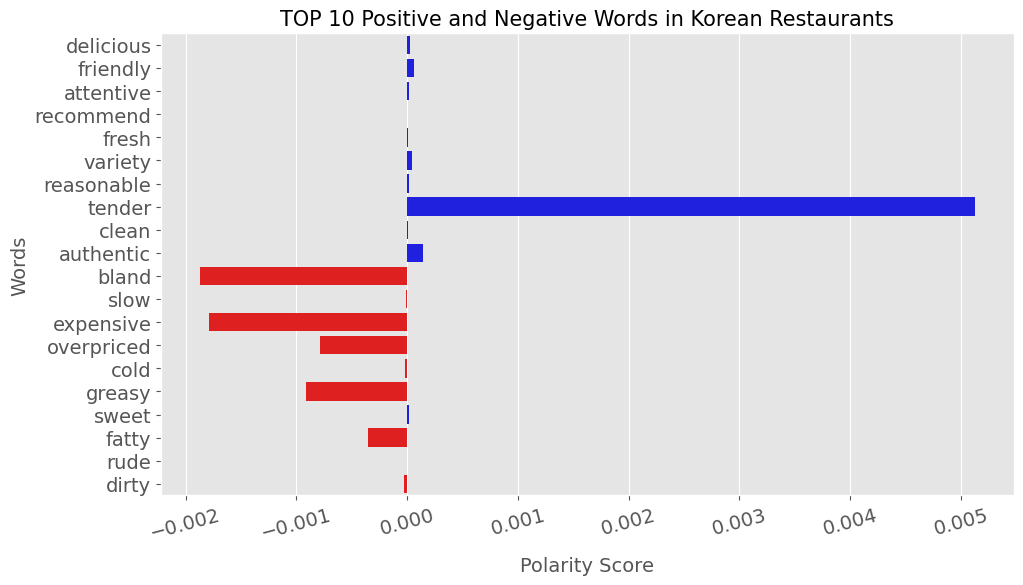

In [49]:
plt.figure(figsize=(11,6))
colors = ['red' if c < 0 else 'blue' for c in Korean_top_words.values]
sns.barplot(y=Korean_top_words.index, x=Korean_top_words.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 10 Positive and Negative Words in Korean Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

In [50]:
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': list(vectorizer.vocabulary_.keys())})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=list(vectorizer.vocabulary_.keys()))
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',                                                   'favorite','loved','perfect','gem','perfectly','wonderful',                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',                                                    'fabulous']
    unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',                                                    'lacking','terrible','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score


In [51]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)

In [52]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df

#### Japanese

In [53]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])

Total 13683 number of reviews


In [54]:
Japanese_polarity_score = get_polarity_score(Japanese_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [55]:
get_top_words(Japanese_polarity_score, 'positive')

,score,frequency,polarity
word,,,
contaminated,0.3652,5735,0.1531
problematic,0.6599,2735,0.1319
weaker,0.1729,5983,0.0756
loves,0.3915,2528,0.0723
disapointed,0.3414,2133,0.0532
detracted,0.2434,2693,0.0479
inefficient,0.4062,1561,0.0463
concerns,0.5394,1097,0.0432
glee,0.2959,1715,0.0371


In [56]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
restless,-0.1104,2803,-0.0226
comfortable,-0.3402,482,-0.0120
cheating,-0.1786,842,-0.0110
grateful,-0.3828,390,-0.0109
exceeded,-0.3441,224,-0.0056
rumor,-0.3635,211,-0.0056
conveniently,-0.3849,174,-0.0049
dishonest,-0.4575,128,-0.0043
rectification,-0.0651,843,-0.0040


In [57]:
Japanese_top_positive_words = ['delicious','friendly','fresh','recommend','fun','reasonable',
                               'creative','clean','variety','attentive']
Japanese_top_negative_words = ['hard','cold','wrong','slow','bland','dark','expensive',
                               'rude','overpriced','crowded']
Japanese_top_words = Japanese_polarity_score.loc[Japanese_top_positive_words+Japanese_top_negative_words,'polarity']

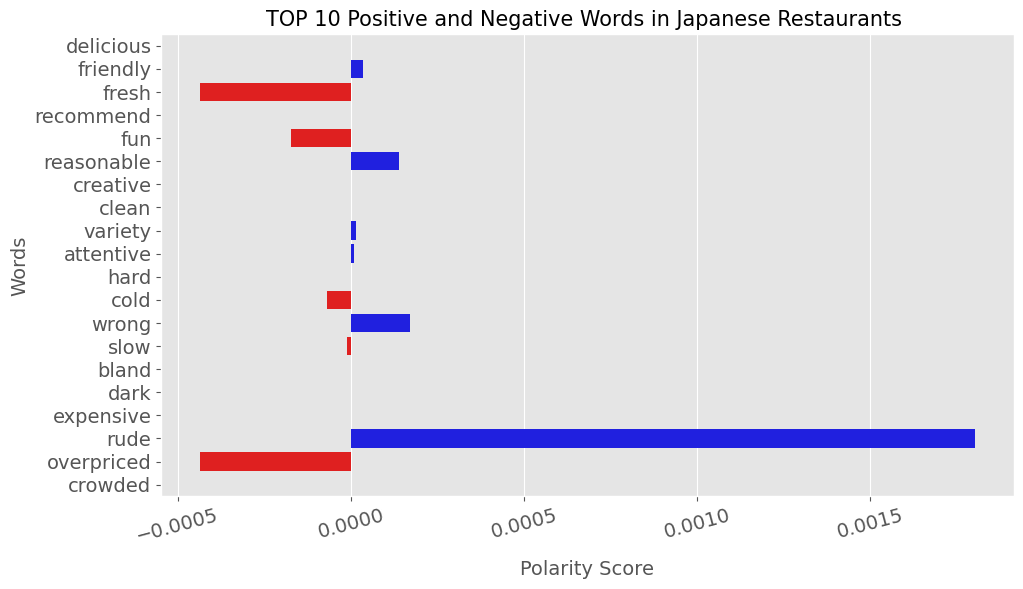

In [58]:
plot_top_words(Japanese_top_words,'Japanese')

#### Thai

In [59]:
Thai_reviews = get_dataset('Thai')
Thai_train = split_data(Thai_reviews, 0.8)
print('Total %d number of reviews' % Thai_train.shape[0])

Total 17973 number of reviews


In [60]:
Thai_polarity_score = get_polarity_score(Thai_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [61]:
get_top_words(Thai_polarity_score,'positive')

,score,frequency,polarity
word,,,
downhill,0.6628,4367,0.1610
enchanting,0.3896,7069,0.1532
complementary,0.5006,3657,0.1018
crisis,0.6128,2487,0.0848
sophisticated,0.1483,8187,0.0675
crabby,0.3355,3006,0.0561
officious,0.4450,2231,0.0552
peaceful,0.5600,1747,0.0544
reproach,0.3656,2438,0.0496


In [62]:
get_top_words(Thai_polarity_score,'negative')

,score,frequency,polarity
word,,,
longing,-0.1390,3612,-0.0279
aloof,-0.2198,1018,-0.0125
chic,-0.3052,592,-0.0101
relief,-0.2865,541,-0.0086
gracious,-0.9797,119,-0.0065
intense,-0.4839,192,-0.0052
swelling,-0.2651,311,-0.0046
wowed,-0.3678,206,-0.0042
reluctantly,-0.3969,183,-0.0040


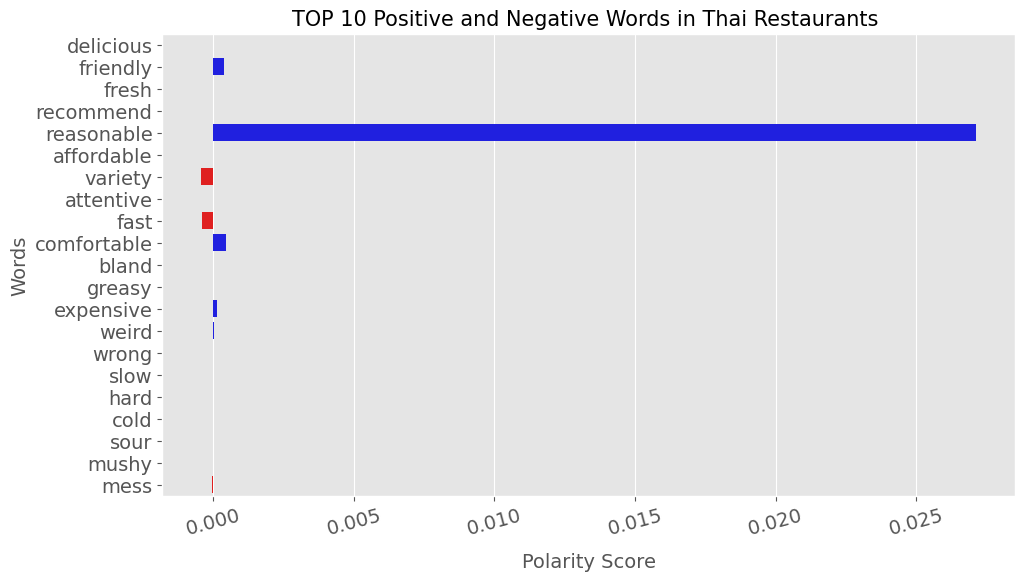

In [63]:
Thai_top_positive_words = ['delicious','friendly','fresh','recommend','reasonable','affordable','variety',
                           'attentive','fast','comfortable']
Thai_top_negative_words = ['bland','greasy','expensive','weird','wrong','slow','hard','cold','sour','mushy','mess']
Thai_top_words = Thai_polarity_score.loc[Thai_top_positive_words+Thai_top_negative_words,'polarity']
plot_top_words(Thai_top_words, 'Thai')

#### Chinese

In [64]:
Chinese_reviews = get_dataset('Chinese')
Chinese_train = split_data(Chinese_reviews, 0.85)
print('Total %d number of reviews' % Chinese_train.shape[0])

Total 23057 number of reviews


In [65]:
Chinese_polarity_score = get_polarity_score(Chinese_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [66]:
get_top_words(Chinese_polarity_score,'positive')

,score,frequency,polarity
word,,,
acrid,0.3971,7363,0.1268
miserable,0.7159,3966,0.1231
sad,0.5128,4194,0.0933
celebratory,0.1952,9981,0.0845
satisfied,0.7049,2116,0.0647
neatly,0.4424,3138,0.0602
wins,0.4997,2127,0.0461
amazed,0.6510,1454,0.0411
bent,0.2744,2918,0.0347


In [67]:
get_top_words(Chinese_polarity_score,'negative')

,score,frequency,polarity
word,,,
steady,-0.0871,4698,-0.0178
nasty,-0.3227,788,-0.0110
obscene,-0.2145,1149,-0.0107
interests,-0.3788,572,-0.0094
trusted,-0.0553,3505,-0.0084
inexpensive,-0.3928,425,-0.0072
snag,-0.1084,1509,-0.0071
comfortable,-0.7902,169,-0.0058
redundancy,-0.3385,383,-0.0056


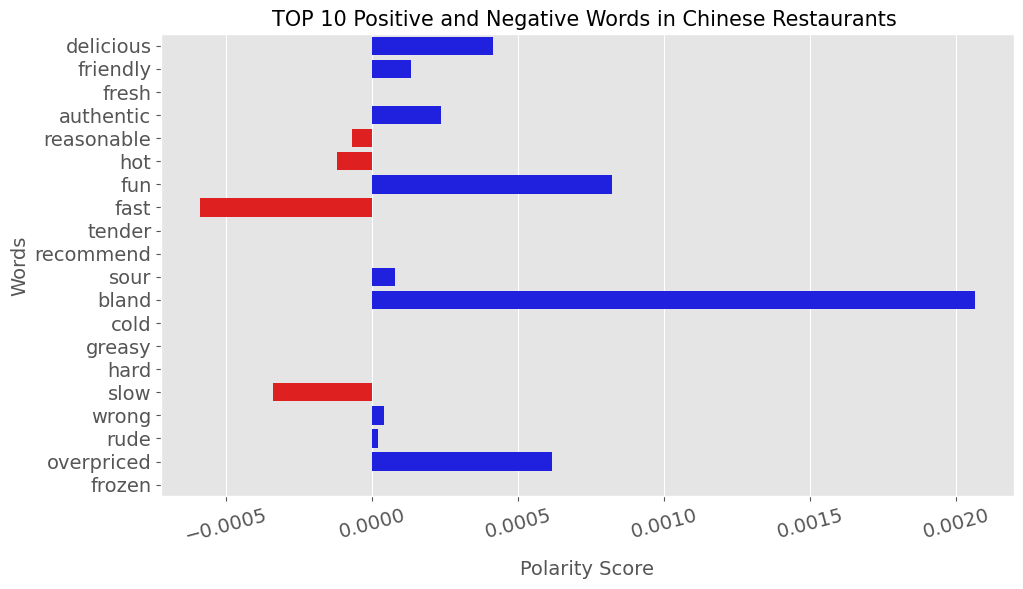

In [68]:
Chinese_top_positive_words = ['delicious','friendly','fresh','authentic','reasonable','hot','fun',
                           'fast','tender','recommend']
Chinese_top_negative_words = ['sour','bland','cold','greasy','hard','slow','wrong','rude','overpriced','frozen']
Chinese_top_words = Chinese_polarity_score.loc[Chinese_top_positive_words+Chinese_top_negative_words,'polarity']
plot_top_words(Chinese_top_words, 'Chinese')

#### Vietnamese

In [69]:
Vietnamese_reviews = get_dataset('Vietnamese')
Vietnamese_train = split_data(Vietnamese_reviews, 0.7)
print('Total %d number of reviews' % Vietnamese_train.shape[0])

Total 22262 number of reviews


In [70]:
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [71]:
get_top_words(Vietnamese_polarity_score,'positive')

,score,frequency,polarity
word,,,
appropriate,0.6198,5264,0.1466
worried,0.5194,4700,0.1097
gloriously,0.2852,8170,0.1047
dense,0.1929,11168,0.0968
treacherous,0.3750,3800,0.0640
admire,0.6150,1675,0.0463
devastated,0.2358,4292,0.0455
astonishment,0.6763,1425,0.0433
pain,0.4029,2365,0.0428


In [72]:
get_top_words(Vietnamese_polarity_score,'negative')

,score,frequency,polarity
word,,,
dissappointed,-0.1141,4846,-0.0248
pretend,-0.4294,602,-0.0116
crappy,-0.1601,1518,-0.0109
recommended,-0.3327,686,-0.0103
vomit,-0.2712,617,-0.0075
losing,-0.1425,1032,-0.0066
ample,-0.7585,170,-0.0058
whining,-0.1946,548,-0.0048
hefty,-0.2648,342,-0.0041


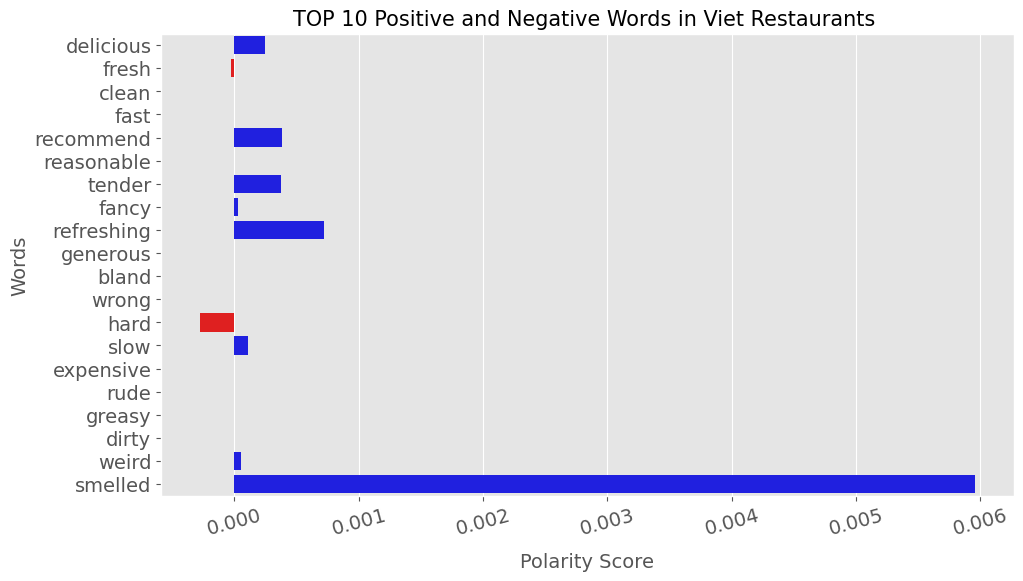

In [73]:
Viet_top_positive_words = ['delicious','fresh','clean','fast','recommend','reasonable','tender',
                           'fancy','refreshing','generous']
Viet_top_negative_words = ['bland','wrong','hard','slow','expensive','rude','greasy','dirty','weird','smelled']
Viet_top_words = Vietnamese_polarity_score.loc[Viet_top_positive_words+Viet_top_negative_words,'polarity']
plot_top_words(Viet_top_words,'Viet')

#### French

In [74]:
French_reviews = get_dataset('French')
French_train = split_data(French_reviews, 0.7)
print('Total %d number of reviews' % French_train.shape[0])

Total 23977 number of reviews


In [75]:
French_polarity_score = get_polarity_score(French_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [76]:
get_top_words(French_polarity_score,'positive')

,score,frequency,polarity
word,,,
killer,0.5270,6569,0.1444
stunned,0.2363,10959,0.1080
scrambled,0.3942,4920,0.0809
lucky,0.3713,5146,0.0797
itch,0.5160,2981,0.0642
abound,0.4427,3176,0.0586
privileged,0.1015,10230,0.0433
sickeningly,0.4674,2016,0.0393
bump,0.3905,2202,0.0359


In [77]:
get_top_words(French_polarity_score, 'negative')

,score,frequency,polarity
word,,,
haters,-0.1129,5437,-0.0256
impeccable,-0.2858,1598,-0.0190
reputation,-0.5545,707,-0.0163
heavenly,-0.4052,665,-0.0112
awed,-0.4984,386,-0.0080
growl,-0.3097,475,-0.0061
obsessions,-0.3582,334,-0.0050
unclean,-0.1484,773,-0.0048
outlaw,-0.5076,217,-0.0046


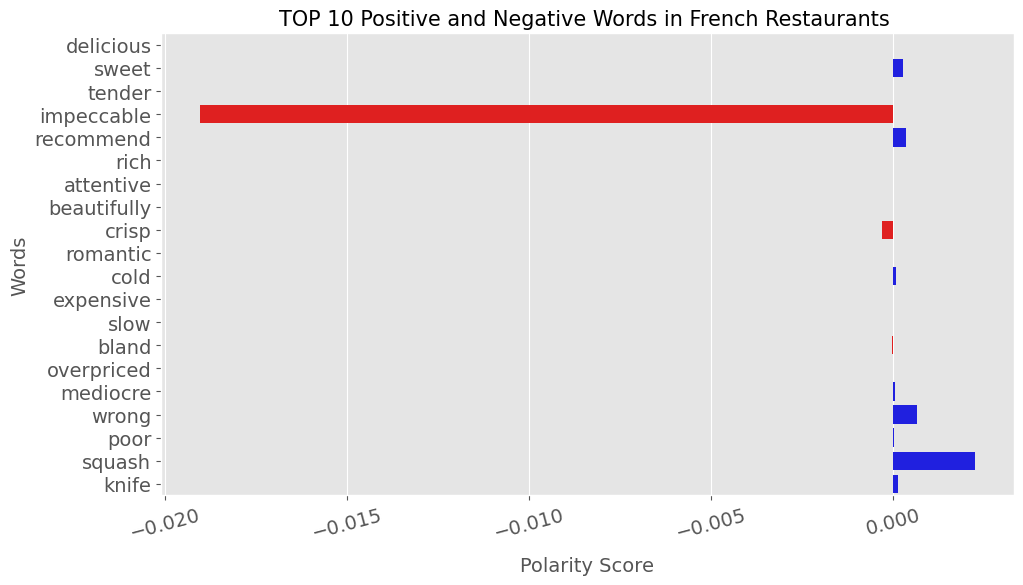

In [78]:
French_top_positive_words = ['delicious','sweet','tender','impeccable','recommend','rich','attentive',
                             'beautifully','crisp','romantic']
French_top_negative_words = ['cold','expensive','slow','bland','overpriced','mediocre','wrong',
                             'poor','squash','knife']
French_top_words = French_polarity_score.loc[French_top_positive_words+French_top_negative_words,'polarity']
plot_top_words(French_top_words,'French')

#### Italian

In [79]:
Italian_reviews = get_dataset('Italian')
Italian_train = split_data(Italian_reviews, 0.9)
print('Total %d number of reviews' % Italian_train.shape[0])

Total 35277 number of reviews


In [80]:
Italian_polarity_score = get_polarity_score(Italian_train)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [81]:
get_top_words(Italian_polarity_score, 'positive',30)

,score,frequency,polarity
word,,,
patient,0.7223,7563,0.1549
stupidly,0.3526,15458,0.1545
pleasing,0.4820,6488,0.0886
frozen,0.5802,5127,0.0843
turmoil,0.1591,14322,0.0646
critic,0.5860,3644,0.0605
attractively,0.6789,2763,0.0532
witty,0.3445,4735,0.0462
exemplary,0.5603,2076,0.0330


In [82]:
get_top_words(Italian_polarity_score, 'negative',30)

,score,frequency,polarity
word,,,
annoy,-0.0979,6383,-0.0177
object,-0.4250,947,-0.0114
heaven,-0.1480,2129,-0.0089
incorrect,-0.2862,1075,-0.0087
yay,-0.4743,443,-0.0060
affluent,-0.1799,874,-0.0045
resent,-0.2210,668,-0.0042
static,-0.1898,777,-0.0042
hasty,-0.6965,211,-0.0042


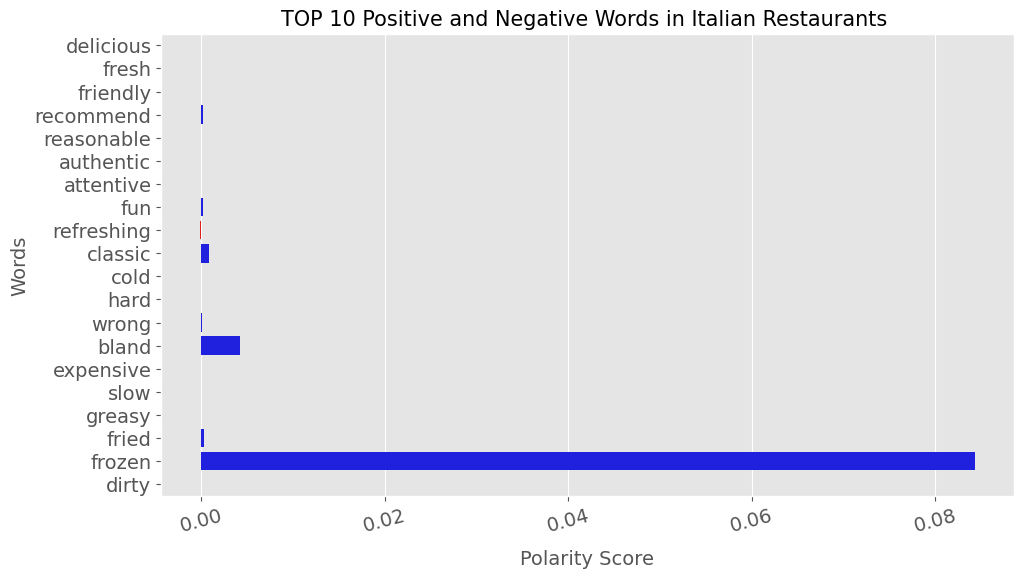

In [83]:
Italian_top_positive_words = ['delicious','fresh','friendly','recommend','reasonable','authentic',
                             'attentive','fun','refreshing','classic']
Italian_top_negative_words = ['cold','hard','wrong','bland','expensive','slow','greasy','fried','frozen','dirty']
Italian_top_words = Italian_polarity_score.loc[Italian_top_positive_words+Italian_top_negative_words,'polarity']
plot_top_words(Italian_top_words,'Italian')

### Combine all top words to compare among different cuisine typies

In [84]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_positive_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.loc[0,i] = word

In [85]:
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_positive_words):
    cuisine_positive_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_positive_words):
    cuisine_positive_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_positive_words):
    cuisine_positive_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_positive_words):
    cuisine_positive_words.iloc[4,i] = word
for i,word in enumerate(French_top_positive_words):
    cuisine_positive_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_positive_words):
    cuisine_positive_words.iloc[6,i] = word

cuisine_positive_words.drop(9,axis=1,inplace=True)
cuisine_positive_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_positive_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_positive_words.set_index('cuisine', inplace=True)

In [86]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_negative_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.loc[0,i] = word

In [87]:
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_negative_words):
    cuisine_negative_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_negative_words):
    cuisine_negative_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_negative_words):
    cuisine_negative_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_negative_words):
    cuisine_negative_words.iloc[4,i] = word
for i,word in enumerate(French_top_negative_words):
    cuisine_negative_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_negative_words):
    cuisine_negative_words.iloc[6,i] = word

cuisine_negative_words.drop(9,axis=1,inplace=True)
cuisine_negative_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_negative_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_negative_words.set_index('cuisine', inplace=True)

In [88]:
cuisine_positive_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,delicious,friendly,attentive,recommend,fresh,variety,reasonable,tender,clean,authentic
Japanese,delicious,friendly,fresh,recommend,fun,reasonable,creative,clean,variety,attentive
Chinese,delicious,friendly,fresh,authentic,reasonable,hot,fun,fast,tender,recommend
Thai,delicious,friendly,fresh,recommend,reasonable,affordable,variety,attentive,fast,comfortable
Vietnamese,delicious,fresh,clean,fast,recommend,reasonable,tender,fancy,refreshing,generous
French,delicious,sweet,tender,impeccable,recommend,rich,attentive,beautifully,crisp,romantic
Italian,delicious,fresh,friendly,recommend,reasonable,authentic,attentive,fun,refreshing,classic


In [89]:
cuisine_negative_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,bland,slow,expensive,overpriced,cold,greasy,sweet,fatty,rude,dirty
Japanese,hard,cold,wrong,slow,bland,dark,expensive,rude,overpriced,crowded
Chinese,sour,bland,cold,greasy,hard,slow,wrong,rude,overpriced,frozen
Thai,bland,greasy,expensive,weird,wrong,slow,hard,cold,sour,mushy
Vietnamese,bland,wrong,hard,slow,expensive,rude,greasy,dirty,weird,smelled
French,cold,expensive,slow,bland,overpriced,mediocre,wrong,poor,squash,knife
Italian,cold,hard,wrong,bland,expensive,slow,greasy,fried,frozen,dirty


# 5. Our Findings

Our analysis shows that customers highly value taste when evaluating a restaurant, with 'delicious' being the most commonly used positive word for most restaurant types. Additionally, friendly service appears to be a key factor contributing to high scores, as 'friendly' ranks first for most cuisine types. Freshness is also highly valued in terms of food flavor, as indicated by customer reviews. These findings can be useful in guiding future marketing strategies and improvements for restaurants, such as focusing on enhancing taste and freshness while providing friendly service to attract and retain customers.

The characteristics of different restaurant categories vary significantly, as evidenced by customer reviews. Vietnamese and Italian cuisine receive positive feedback due to the freshness of their food, while French restaurants are praised for their sweet dishes. However, sweet food can have a negative impact on the reputation of Korean restaurants. Positive reviews for Korean, Japanese, Chinese, and Thai cuisine often mention friendly service, with Korean restaurants standing out for their attentive staff. The range of food offerings is another factor contributing to high scores for Korean, Japanese, and Thai cuisine types. Japanese restaurants are known for their fun and creative approach to dining, while customers tend to prefer classic Italian dishes. In the case of French cuisine, the romantic and elegant ambiance plays a significant role in attracting positive reviews.

The negative word list reveals several issues faced by different cuisine types. Korean, Thai, and Vietnamese restaurants tend to receive complaints about bland food, which suggests that customers expect spicier dishes from these cuisines. French, Italian, and Japanese restaurants, on the other hand, may receive low scores due to cold food, dark and crowded environments, and greasy food respectively. Chinese cuisine is often criticized for being sour, while Korean and French restaurants receive negative feedback for slow service. French cuisine also receives negative reviews for its high prices.

Our analysis has the potential to extract key features from any set of reviews, which could be valuable information for restaurant owners once they receive a sufficient number of Yelp reviews. By analyzing customer feedback, they can gain insights into why customers love or dislike their restaurants. For example, positive reviews may be due to the freshness of the food, while negative reviews could be caused by high prices. In addition, owners can compare their restaurant to similar establishments within the same cuisine type, helping them to identify areas for improvement and make informed business decisions.

# 6. Recommendation

## Korean

- Prioritize taste and use fresh ingredients
- Train waitstaff to be professional and friendly
- Advertise on social media, adjust prices if needed, and make menu creations
- Keep the environment clean

## Japanese

- Use fresh ingredients and make menu creations
- Train waitstaff to be friendly and avoid mistakes
- Invest in technology to keep raw ingredients fresh
- Keep the environment clean and make adjustments based on customer feedback

## Chinese

- Prioritize delicious and authentic food
- Train waitstaff to be professional and fast
- Set reasonable prices
- Use fresh ingredients and improve cooking techniques

## Thai

- Prioritize tasty and fresh food with high variety
- Train waitstaff to be friendly, attentive, and fast
- Keep reasonable prices
- Keep the environment clean and comfortable

## Vietnamese

- Prioritize tender and generous servings of food
- Keep the environment clean and fancy
- Set reasonable prices
- Train waitstaff to be professional, nice, and avoid mistakes

## French

- Keep the environment clean and fancy
- Prioritize tender and generous servings of food
- Train waitstaff to be professional, nice, and avoid mistakes

## Italian 

- Keep the environment clean and fancy
- Prioritize tender and generous servings of food
- Train waitstaff to be professional, nice, and avoid mistakes